Found 763 patch centroids.
Number of neighbor angles: 4420


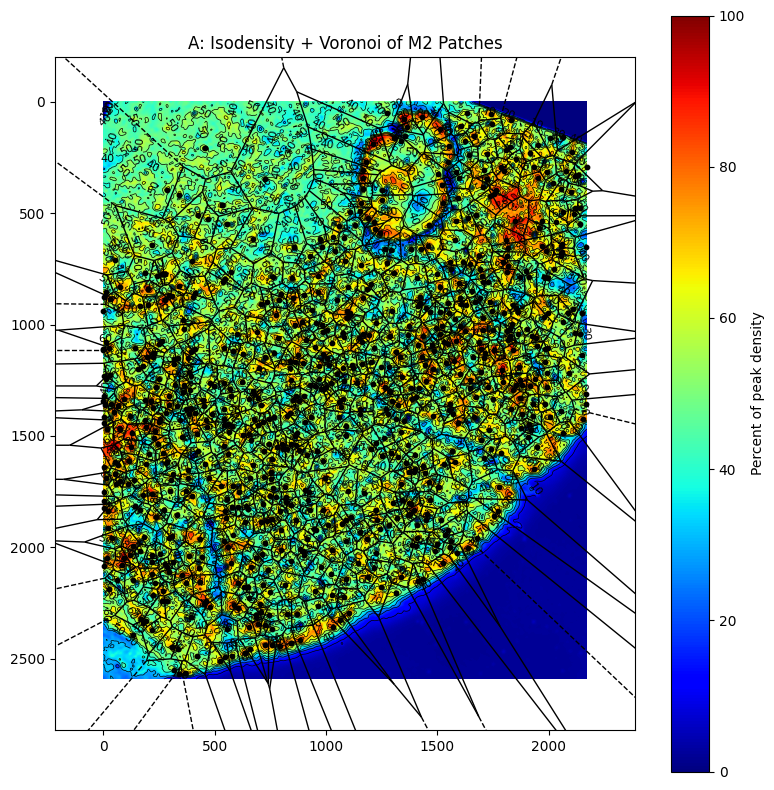

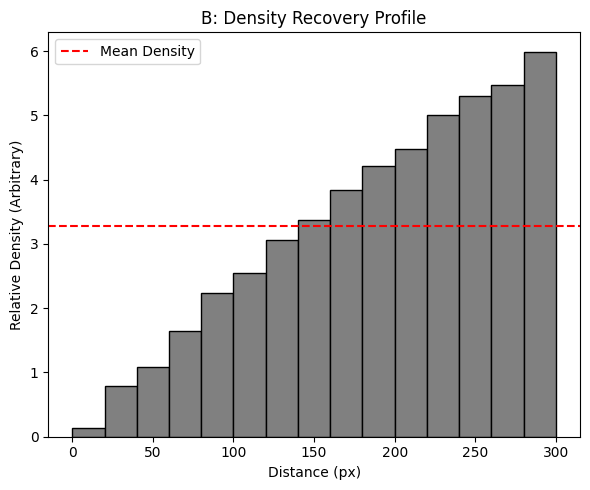

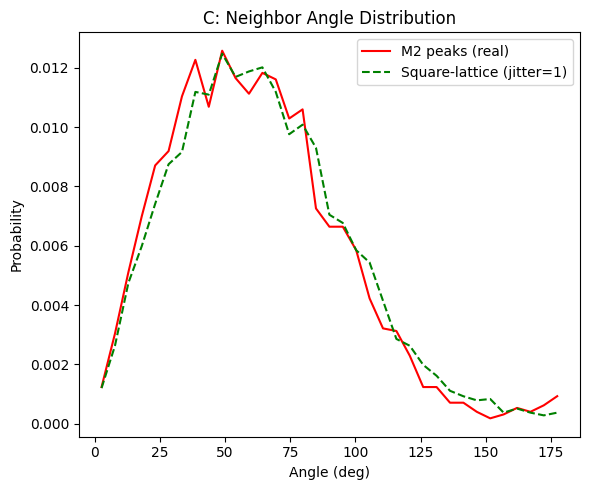

K-S test vs. model: p=0.00582, stat=0.0367


In [56]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from skimage.measure import label, regionprops
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay
from scipy.stats import ks_2samp

###############################################################################
# HELPER FUNCTIONS FOR MODEL DISTRIBUTIONS
###############################################################################
def generate_square_lattice(num_points=100, spacing=50, jitter=0.1, 
                            xlim=(0,1000), ylim=(0,1000), seed=0):
    """
    Build a square lattice with approximate 'spacing' in x & y,
    plus random jitter (0 = perfect grid, 1 ~ random Poisson).
    We'll tile until we exceed xlim, ylim, then randomly downsample
    if we get more points than needed.
    """
    rng = np.random.default_rng(seed)

    # 1) Perfect grid
    xs = np.arange(xlim[0], xlim[1], spacing)
    ys = np.arange(ylim[0], ylim[1], spacing)
    grid_points = []
    for y in ys:
        for x in xs:
            grid_points.append([x, y])
    grid_points = np.array(grid_points, dtype=np.float32)

    # 2) Jitter each point
    max_offset = jitter * spacing
    offsets = rng.uniform(-max_offset, max_offset, size=grid_points.shape)
    grid_points += offsets

    # 3) If we have too many points, randomly downsample
    if len(grid_points) > num_points:
        sel = rng.choice(len(grid_points), size=num_points, replace=False)
        grid_points = grid_points[sel]

    return grid_points

def gabriel_neighbor_angles(points):
    """
    Given an array of points (x, y),
    1) build Delaunay
    2) find Gabriel edges
    3) measure angles among neighbors
    returns an array of angles in degrees
    """
    from scipy.spatial import Delaunay
    tri = Delaunay(points)
    edges = set()
    for simplex in tri.simplices:
        e_pairs = [(simplex[0], simplex[1]),
                   (simplex[1], simplex[2]),
                   (simplex[2], simplex[0])]
        for (i1, i2) in e_pairs:
            if i1 > i2:
                i1, i2 = i2, i1
            x1, y1 = points[i1]
            x2, y2 = points[i2]
            mx = 0.5*(x1 + x2)
            my = 0.5*(y1 + y2)
            r = 0.5 * np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            d_all = np.sqrt((points[:,0]-mx)**2 + (points[:,1]-my)**2)
            inside = np.sum(d_all < r - 1e-7)
            if inside <= 2:
                edges.add((i1, i2))

    # adjacency
    N = len(points)
    neighbors = [[] for _ in range(N)]
    for (i1, i2) in edges:
        neighbors[i1].append(i2)
        neighbors[i2].append(i1)

    angles_deg = []
    for i in range(N):
        nb = neighbors[i]
        if len(nb) < 2:
            continue
        cx, cy = points[i]
        def polar_angle(idx):
            return np.arctan2(points[idx][1]-cy, points[idx][0]-cx)
        nb_sorted = sorted(nb, key=polar_angle)
        for k in range(len(nb_sorted)):
            j1 = nb_sorted[k]
            j2 = nb_sorted[(k+1) % len(nb_sorted)]
            if j1 == j2:
                continue
            v1x, v1y = points[j1][0]-cx, points[j1][1]-cy
            v2x, v2y = points[j2][0]-cx, points[j2][1]-cy
            dot = v1x*v2x + v1y*v2y
            mag1 = np.hypot(v1x, v1y)
            mag2 = np.hypot(v2x, v2y)
            if mag1<1e-9 or mag2<1e-9:
                continue
            cosA = np.clip(dot/(mag1*mag2), -1, 1)
            angle = np.degrees(np.arccos(cosA))
            angles_deg.append(angle)
    return np.array(angles_deg)

###############################################################################
# MAIN ANALYSIS PIPELINE (Your existing code with modifications)
###############################################################################
# 1) Read the raw grayscale image & apply Gaussian filter
img_path = "./MAX_118_ACCGFPRSCtdTLGNmCeru_10X_5-1.png"
img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)

sigma_gauss = 5.0
img_filtered = gaussian_filter(img_gray, sigma=sigma_gauss)

# 2) Background Subtraction (morphological opening)
kernel_size = 50
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
background = cv2.morphologyEx(img_filtered, cv2.MORPH_OPEN, kernel)
img_sub = img_filtered - background
img_sub[img_sub < 0] = 0

# 3) Threshold
global_peak = img_sub.max()
threshold_fraction = 0.5  # user-tunable
th_val = threshold_fraction * global_peak
_, bw = cv2.threshold(img_sub, th_val, 1, cv2.THRESH_BINARY)

# 4) Find centroids
labels = label(bw > 0, connectivity=2)
props = regionprops(labels)
centroids = []
for rp in props:
    cy, cx = rp.centroid
    centroids.append((cx, cy))
centroids = np.array(centroids)
print(f"Found {len(centroids)} patch centroids.")
if len(centroids) < 3:
    print("Not enough patches found. Adjust thresholds or filtering!")
    exit()

# 5) Density Recovery Profile
all_dist = []
for i,c in enumerate(centroids):
    dx = centroids[:,0]-c[0]
    dy = centroids[:,1]-c[1]
    dd = np.sqrt(dx*dx + dy*dy)
    dd = dd[dd>0]
    all_dist.append(dd)
all_dist = np.concatenate(all_dist)

max_dist = 300
bin_size = 20
bins = np.arange(0, max_dist+bin_size, bin_size)
hist, edges = np.histogram(all_dist, bins=bins)
num_centroids = len(centroids)
drp = hist / float(num_centroids)
bin_centers = 0.5*(edges[:-1]+edges[1:])

# 6) Voronoi
vor = Voronoi(centroids)

# 7) Gabriel Graph -> neighbor angles
tri = Delaunay(centroids)
gabriel_edges = set()
for simplex in tri.simplices:
    v0, v1, v2 = simplex
    e_pairs = [(v0, v1), (v1, v2), (v2, v0)]
    for (i1,i2) in e_pairs:
        if i1>i2: 
            i1, i2 = i2, i1
        x1,y1 = centroids[i1]
        x2,y2 = centroids[i2]
        mx,my = 0.5*(x1+x2), 0.5*(y1+y2)
        r = 0.5*np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        d_all = np.sqrt((centroids[:,0]-mx)**2 + (centroids[:,1]-my)**2)
        inside = np.sum(d_all < r - 1e-7)
        if inside <= 2:
            gabriel_edges.add((i1,i2))

neighbors = [[] for _ in range(num_centroids)]
for (i1,i2) in gabriel_edges:
    neighbors[i1].append(i2)
    neighbors[i2].append(i1)

all_angles = []
for i in range(num_centroids):
    nb = neighbors[i]
    if len(nb)<2:
        continue
    cx,cy = centroids[i]
    def polar_angle(j):
        return np.arctan2(centroids[j][1]-cy, centroids[j][0]-cx)
    nb_sorted = sorted(nb, key=polar_angle)
    for k in range(len(nb_sorted)):
        j1 = nb_sorted[k]
        j2 = nb_sorted[(k+1)%len(nb_sorted)]
        if j1==j2:
            continue
        v1x, v1y = centroids[j1][0]-cx, centroids[j1][1]-cy
        v2x, v2y = centroids[j2][0]-cx, centroids[j2][1]-cy
        dot = v1x*v2x + v1y*v2y
        mag1 = np.hypot(v1x, v1y)
        mag2 = np.hypot(v2x, v2y)
        if mag1<1e-9 or mag2<1e-9:
            continue
        cosA = np.clip(dot/(mag1*mag2), -1,1)
        angle_deg = np.degrees(np.arccos(cosA))
        all_angles.append(angle_deg)
all_angles = np.array(all_angles)
print("Number of neighbor angles:", len(all_angles))

###############################################################################
# 8) PLOTTING
###############################################################################
# (A) Isodensity + Voronoi
figA, axA = plt.subplots(figsize=(8,8))
img_percent = (img_filtered/(img_filtered.max()+1e-7))*100
imA = axA.imshow(img_percent, cmap='jet', vmin=0, vmax=100, origin='upper')
cbarA = plt.colorbar(imA, ax=axA, label="Percent of peak density")
levels = np.arange(10,110,10)
cs = axA.contour(img_percent, levels=levels, colors='k', linewidths=0.5)
axA.clabel(cs, inline=True, fontsize=8)

voronoi_plot_2d(vor, ax=axA, show_vertices=False, show_points=False)
axA.scatter(centroids[:,0], centroids[:,1], c='black', s=10)
axA.set_title("A: Isodensity + Voronoi of M2 Patches")
axA.invert_yaxis()
plt.tight_layout()
plt.show()

# (B) Density Recovery Profile
figB, axB = plt.subplots(figsize=(6,5))
axB.bar(bin_centers, drp, width=bin_size, align='center',
        color='gray', edgecolor='black')
axB.axhline(np.mean(drp), color='red', linestyle='--', label="Mean Density")
axB.set_xlabel("Distance (px)")
axB.set_ylabel("Relative Density (Arbitrary)")
axB.set_title("B: Density Recovery Profile")
axB.legend()
plt.tight_layout()
plt.show()

# (C) Angle distribution: real data vs. square-lattice model
figC, axC = plt.subplots(figsize=(6,5))
bins_angles = np.linspace(0,180,36)
hist_real, _ = np.histogram(all_angles, bins=bins_angles, density=True)
centers_ang = 0.5*(bins_angles[:-1]+bins_angles[1:])
axC.plot(centers_ang, hist_real, 'r-', label="M2 peaks (real)")

# --- Generate a model (square lattice w/ jitter=0.3)
num_sim = len(centroids)
xmax, ymax = img_gray.shape[1], img_gray.shape[0]
square_pts = generate_square_lattice(num_points=num_sim,
                                     spacing=50, 
                                     jitter=1, 
                                     xlim=(0,xmax),
                                     ylim=(0,ymax),
                                     seed=42)
model_angles = gabriel_neighbor_angles(square_pts)
hist_model, _ = np.histogram(model_angles, bins=bins_angles, density=True)
axC.plot(centers_ang, hist_model, 'g--', label="Square-lattice (jitter=1)")

axC.set_xlabel("Angle (deg)")
axC.set_ylabel("Probability")
axC.set_title("C: Neighbor Angle Distribution")
axC.legend()
plt.tight_layout()
plt.show()

# K-S test
stat, p_val = ks_2samp(all_angles, model_angles)
print(f"K-S test vs. model: p={p_val:.3g}, stat={stat:.3g}")


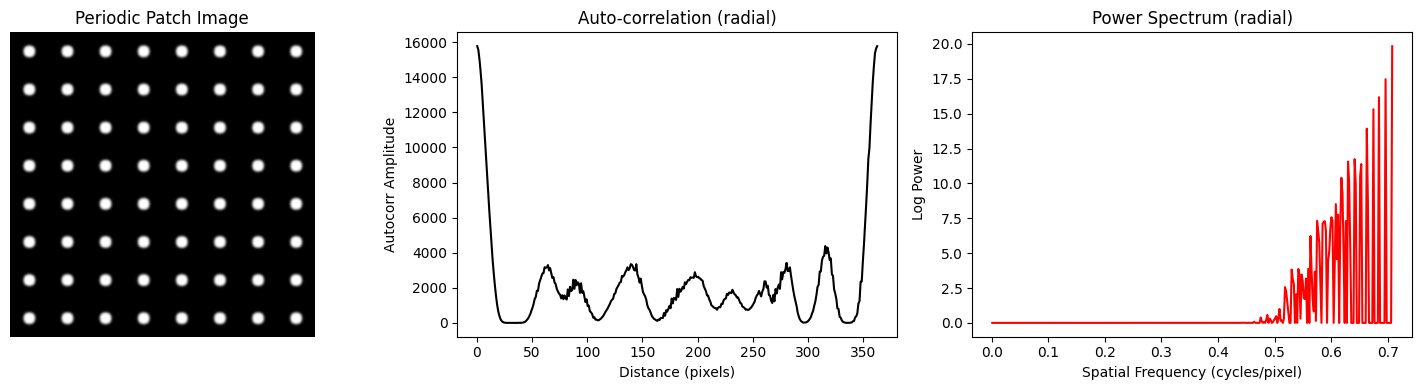

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def generate_periodic_patches(img_size=512, spacing=64, patch_radius=10, blur_sigma=2.0):
    """
    Creates a 2D image with periodically spaced "patches" (Gaussian blobs) on a grid.
    This is just a demo for showing a clear periodic pattern.
    """
    img = np.zeros((img_size, img_size), dtype=np.float32)

    # Place circular patches on a grid
    for cy in range(spacing//2, img_size, spacing):
        for cx in range(spacing//2, img_size, spacing):
            y, x = np.ogrid[:img_size, :img_size]
            mask = (x - cx)**2 + (y - cy)**2 <= patch_radius**2
            img[mask] = 1.0

    # Optional blur for more realistic edges
    if blur_sigma > 0:
        img = gaussian_filter(img, sigma=blur_sigma)

    return img

def fft_autocorrelation(image):
    """
    2D autocorrelation via FFT:
      AC = ifft2( |fft2(I)|^2 ).
    Returns a 2D numpy array (unshifted).
    """
    F = np.fft.fft2(image)
    power = F * np.conj(F)
    ac = np.fft.ifft2(power).real
    return ac

def fft_power_spectrum(image):
    """
    2D power spectrum = |FFT(I)|^2.
    Returns a 2D array (unshifted).
    """
    F = np.fft.fft2(image)
    ps = np.abs(F)**2
    return ps

def radial_profile_1d(data2d, center=None, bin_size=1.0):
    """
    Compute the radial average (1D profile) of a 2D array 'data2d'.
    'center' is (x0, y0). If None, use the image center.
    'bin_size' sets the step in radius for binning.
    
    Returns:
      r_vals: array of radius bin centers
      profile: array of averaged values at each radius
    """
    ny, nx = data2d.shape
    if center is None:
        center = (nx//2, ny//2)
    cx, cy = center

    # Create a grid of (x,y) coordinates
    y_indices, x_indices = np.indices((ny, nx))
    x_dist = x_indices - cx
    y_dist = y_indices - cy
    r = np.sqrt(x_dist**2 + y_dist**2)

    # Max radius = half the diagonal or so
    r_max = r.max()
    # Create array of radius bin edges
    nbins = int(r_max/bin_size) + 1
    bin_edges = np.arange(nbins+1) * bin_size

    # We'll accumulate sums and counts per bin
    radial_sum = np.zeros(nbins, dtype=np.float64)
    radial_count = np.zeros(nbins, dtype=np.float64)

    # Flatten arrays for speed
    r_flat = r.ravel()
    data_flat = data2d.ravel()

    # Which bin does each pixel belong to?
    bin_index = np.floor(r_flat/bin_size).astype(int)
    bin_index[bin_index>nbins-1] = nbins-1  # clamp

    # Accumulate sums and counts
    for i in range(len(r_flat)):
        b = bin_index[i]
        radial_sum[b] += data_flat[i]
        radial_count[b] += 1

    # Avoid divide-by-zero
    radial_mean = radial_sum / (radial_count + 1e-8)
    # bin centers
    r_vals = (bin_edges[:-1] + bin_edges[1:]) / 2.0

    return r_vals, radial_mean

# -------------------------------------------------------------------------
# Demonstration
# -------------------------------------------------------------------------
if __name__ == "__main__":
    # 1) Generate synthetic periodic image
    img_size = 512
    spacing = 64
    patch_radius = 10
    blur_sigma = 2.0
    image = generate_periodic_patches(img_size, spacing, patch_radius, blur_sigma)

    # 2) Compute 2D autocorrelation & power spectrum
    ac2d = fft_autocorrelation(image)
    ps2d = fft_power_spectrum(image)

    # 3) Radially average
    # Autocorrelation: radius in "real-space" pixels
    ac_r, ac_profile = radial_profile_1d(ac2d, center=(img_size//2, img_size//2), bin_size=1.0)
    
    # Power spectrum: radius in "frequency-space" -> cycles/pixel
    # We'll do radial_profile_1d on ps2d, then define freq = r / (img_size)
    # because for an NxN FFT, the max frequency in cycles/pixel is about 0.5
    ps_r, ps_profile = radial_profile_1d(ps2d, center=(img_size//2, img_size//2), bin_size=1.0)
    # Convert radius in pixel-space to frequency in cycles/pixel
    freq_vals = ps_r / img_size  # simplistic approach

    # Optionally do a log transform of the power for plotting
    ps_profile_log = np.log1p(ps_profile)

    # 4) Plot
    fig, axs = plt.subplots(1,3, figsize=(15,4))

    # (A) Show the synthetic image
    axs[0].imshow(image, cmap='gray')
    axs[0].set_title("Periodic Patch Image")
    axs[0].axis("off")

    # (B) Autocorrelation radial profile
    axs[1].plot(ac_r, ac_profile, 'k-')
    axs[1].set_xlabel("Distance (pixels)")
    axs[1].set_ylabel("Autocorr Amplitude")
    axs[1].set_title("Auto-correlation (radial)")

    # (C) Power spectrum radial profile
    # We'll plot freq (cycles/pixel) vs. log power
    axs[2].plot(freq_vals, ps_profile_log, 'r-')
    axs[2].set_xlabel("Spatial Frequency (cycles/pixel)")
    axs[2].set_ylabel("Log Power")
    axs[2].set_title("Power Spectrum (radial)")

    plt.tight_layout()
    plt.show()


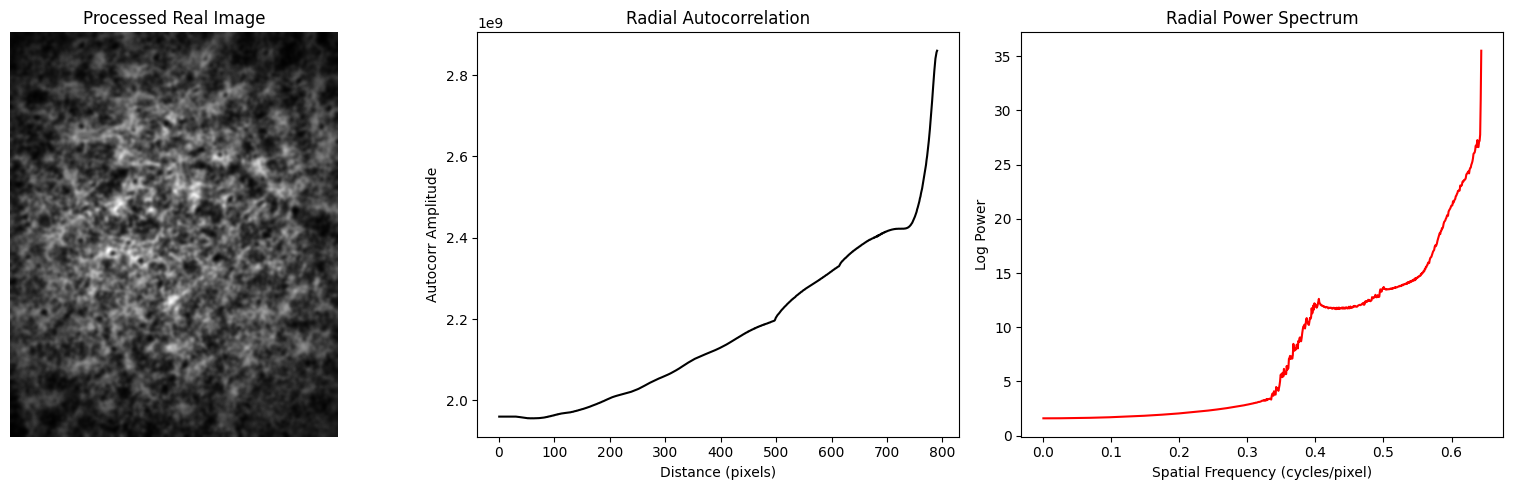

In [67]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def fft_autocorrelation(image):
    """
    2D autocorrelation via FFT:
      AC = ifft2( |fft2(I)|^2 ).
    Returns a 2D numpy array (unshifted).
    """
    F = np.fft.fft2(image)
    power = F * np.conj(F)
    ac = np.fft.ifft2(power).real
    return ac

def fft_power_spectrum(image):
    """
    2D power spectrum = |FFT(I)|^2.
    Returns a 2D array (unshifted).
    """
    F = np.fft.fft2(image)
    ps = np.abs(F)**2
    return ps

def radial_profile_1d(data2d, center=None, bin_size=1.0):
    """
    Compute the radial average (1D profile) of a 2D array 'data2d'.
    'center' is (x0, y0). If None, use image center.
    'bin_size' sets the step in radius (pixels).
    Returns (r_vals, radial_mean).
    """
    ny, nx = data2d.shape
    if center is None:
        center = (nx//2, ny//2)
    cx, cy = center

    y_indices, x_indices = np.indices((ny, nx))
    x_dist = x_indices - cx
    y_dist = y_indices - cy
    r = np.sqrt(x_dist**2 + y_dist**2)
    r_max = r.max()
    nbins = int(r_max/bin_size) + 1
    bin_edges = np.arange(nbins+1) * bin_size

    radial_sum = np.zeros(nbins, dtype=np.float64)
    radial_count = np.zeros(nbins, dtype=np.float64)

    r_flat = r.ravel()
    data_flat = data2d.ravel()
    bin_index = np.floor(r_flat/bin_size).astype(int)
    bin_index[bin_index>nbins-1] = nbins-1  # clamp

    for i in range(len(r_flat)):
        b = bin_index[i]
        radial_sum[b] += data_flat[i]
        radial_count[b] += 1

    radial_mean = radial_sum / (radial_count + 1e-8)
    r_vals = (bin_edges[:-1] + bin_edges[1:]) / 2.0

    return r_vals, radial_mean


if __name__ == "__main__":
    # ------------------------------------------------------
    # 1) LOAD YOUR REAL IMAGE (instead of synthetic patches)
    # ------------------------------------------------------
    img_path = "./MAX_118_ACCGFPRSCtdTLGNmCeru_10X_5-2-1.png"  # Adjust path as needed
    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)

    # Suppose 'img_gray' is your image (H x W).
    H, W = img_gray.shape
    
    # 1) Build a 2D Gaussian window
    #    'sigma_window' controls how big the window's “peak” is.
    sigma_window = 400.0
    y = np.arange(H) - (H/2)
    x = np.arange(W) - (W/2)
    X, Y = np.meshgrid(x, y)
    window_2d = np.exp(-((X**2 + Y**2)/(2 * sigma_window**2)))
    
    # Normalize so peak = 1.0
    window_2d /= window_2d.max()
    
    # 2) Multiply your image by this window
    img_windowed = img_gray * window_2d
    
    # 3) Now do your analysis (autocorrelation, power spectrum, etc.) on 'img_windowed'.

    # (Optional) Apply some smoothing or background subtraction if necessary.
    # For example:
    sigma_gauss = 5.0
    img_blurred = gaussian_filter(img_windowed, sigma=sigma_gauss)

    # ------------------------------------------------------
    # 2) Compute 2D autocorrelation & power spectrum
    # ------------------------------------------------------
    ac2d = fft_autocorrelation(img_blurred)
    ps2d = fft_power_spectrum(img_blurred)

    # ------------------------------------------------------
    # 3) Compute radial profiles
    # ------------------------------------------------------
    # Autocorr vs. distance in real space (pixels)
    r_ac, ac_profile = radial_profile_1d(ac2d, center=(img_blurred.shape[1]//2, 
                                                      img_blurred.shape[0]//2),
                                         bin_size=1.0)

    # Power spectrum vs. frequency
    # r_ps is the radius in pixel coords; freq = r_ps / image_size
    r_ps, ps_profile = radial_profile_1d(ps2d, center=(img_blurred.shape[1]//2, 
                                                       img_blurred.shape[0]//2),
                                         bin_size=1.0)
    freq_vals = r_ps / float(img_blurred.shape[0])  # cycles per pixel (approx.)
    ps_profile_log = np.log1p(ps_profile)

    # ------------------------------------------------------
    # 4) PLOT
    # ------------------------------------------------------
    fig, axs = plt.subplots(1, 3, figsize=(16,5))

    # (A) show the processed image
    axs[0].imshow(img_blurred, cmap='gray')
    axs[0].set_title("Processed Real Image")
    axs[0].axis("off")

    # (B) 1D Autocorrelation radial profile
    axs[1].plot(r_ac, ac_profile, 'k-')
    axs[1].set_xlabel("Distance (pixels)")
    axs[1].set_ylabel("Autocorr Amplitude")
    axs[1].set_title("Radial Autocorrelation")

    # (C) 1D Power spectrum radial profile
    axs[2].plot(freq_vals, ps_profile_log, 'r-')
    axs[2].set_xlabel("Spatial Frequency (cycles/pixel)")
    axs[2].set_ylabel("Log Power")
    axs[2].set_title("Radial Power Spectrum")

    plt.tight_layout()
    plt.show()


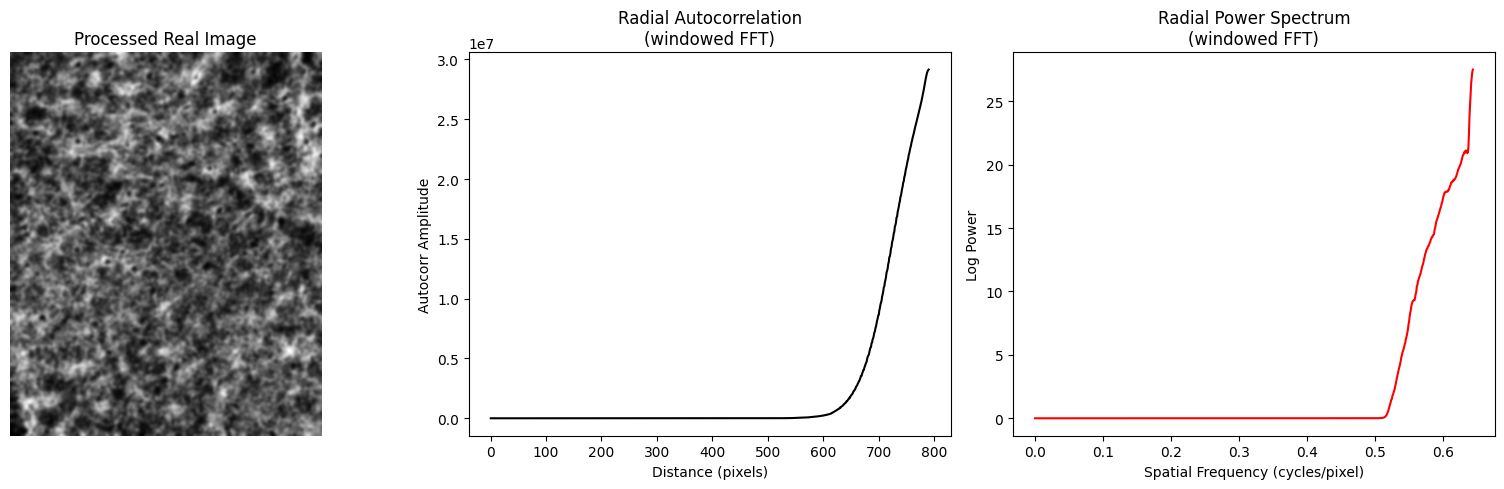

In [73]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

###############################################################################
#  Build a 2D Gaussian window of the same size as the image
###############################################################################
def build_gaussian_window(shape, sigma):
    """
    Create a 2D Gaussian window matching 'shape' = (H, W).
    'sigma' is in pixels (standard deviation).
    Returns window_2d normalized so max=1.0.
    """
    H, W = shape
    y = np.arange(H) - (H / 2.0)
    x = np.arange(W) - (W / 2.0)
    X, Y = np.meshgrid(x, y)
    window_2d = np.exp(-((X**2 + Y**2) / (2 * sigma**2)))
    # Normalize peak to 1
    window_2d /= window_2d.max()
    return window_2d

###############################################################################
#  Windowed FFT-based autocorrelation
###############################################################################
def fft_autocorrelation(image, sigma_window=400.0):
    """
    2D autocorrelation, but apply a 2D Gaussian window first to reduce
    edge effects. The 'sigma_window' controls the window's width (in pixels).
    
    AC = ifft2( |fft2( windowed_image )|^2 ).
    
    Returns a 2D numpy array (unshifted).
    """
    # 1) Build the window (same size as 'image')
    window_2d = build_gaussian_window(image.shape, sigma_window)
    
    # 2) Multiply the image by this window
    img_win = image * window_2d
    
    # 3) Compute FFT => power => ifft
    F = np.fft.fft2(img_win)
    power = F * np.conj(F)
    ac = np.fft.ifft2(power).real
    return ac

###############################################################################
#  Windowed FFT-based power spectrum
###############################################################################
def fft_power_spectrum(image, sigma_window=400.0):
    """
    2D power spectrum = | FFT( windowed_image ) |^2.
    'sigma_window' is the width of the Gaussian window in pixels.
    
    Returns a 2D array (unshifted) of power.
    """
    # 1) Build the window
    window_2d = build_gaussian_window(image.shape, sigma_window)
    
    # 2) Multiply the image by the window
    img_win = image * window_2d
    
    # 3) FFT and take magnitude^2
    F = np.fft.fft2(img_win)
    ps = np.abs(F)**2
    return ps

###############################################################################
# Radial profile code (unchanged)
###############################################################################
def radial_profile_1d(data2d, center=None, bin_size=1.0):
    """
    Compute the radial average (1D profile) of a 2D array 'data2d'.
    'center' is (x0, y0). If None, use image center.
    'bin_size' sets the step in radius (pixels).
    Returns (r_vals, radial_mean).
    """
    ny, nx = data2d.shape
    if center is None:
        center = (nx//2, ny//2)
    cx, cy = center

    y_indices, x_indices = np.indices((ny, nx))
    x_dist = x_indices - cx
    y_dist = y_indices - cy
    r = np.sqrt(x_dist**2 + y_dist**2)
    r_max = r.max()
    nbins = int(r_max/bin_size) + 1
    bin_edges = np.arange(nbins+1) * bin_size

    radial_sum = np.zeros(nbins, dtype=np.float64)
    radial_count = np.zeros(nbins, dtype=np.float64)

    r_flat = r.ravel()
    data_flat = data2d.ravel()
    bin_index = np.floor(r_flat/bin_size).astype(int)
    bin_index[bin_index > nbins-1] = nbins-1  # clamp

    for i in range(len(r_flat)):
        b = bin_index[i]
        radial_sum[b] += data_flat[i]
        radial_count[b] += 1

    radial_mean = radial_sum / (radial_count + 1e-8)
    r_vals = (bin_edges[:-1] + bin_edges[1:]) / 2.0

    return r_vals, radial_mean

###############################################################################
# Demo / main
###############################################################################
if __name__ == "__main__":
    # Load your image
    img_path = "./MAX_118_ACCGFPRSCtdTLGNmCeru_10X_5-2-1.png"
    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)

    # Optional smoothing or background subtraction
    sigma_blur = 5.0
    img_blurred = gaussian_filter(img_gray, sigma=sigma_blur)

    # Compute autocorr & power with windowed FFT
    sigma_window = 50.0
    ac2d = fft_autocorrelation(img_blurred, sigma_window=sigma_window)
    ps2d = fft_power_spectrum(img_blurred, sigma_window=sigma_window)

    # Radial autocorrelation
    r_ac, ac_profile = radial_profile_1d(ac2d)

    # Radial power
    r_ps, ps_profile = radial_profile_1d(ps2d)
    freq_vals = r_ps / float(img_blurred.shape[0])
    ps_profile_log = np.log1p(ps_profile)

    # Plot
    fig, axs = plt.subplots(1, 3, figsize=(16,5))

    axs[0].imshow(img_blurred, cmap='gray')
    axs[0].set_title("Processed Real Image")
    axs[0].axis("off")

    axs[1].plot(r_ac, ac_profile, 'k-')
    axs[1].set_xlabel("Distance (pixels)")
    axs[1].set_ylabel("Autocorr Amplitude")
    axs[1].set_title("Radial Autocorrelation\n(windowed FFT)")

    axs[2].plot(freq_vals, ps_profile_log, 'r-')
    axs[2].set_xlabel("Spatial Frequency (cycles/pixel)")
    axs[2].set_ylabel("Log Power")
    axs[2].set_title("Radial Power Spectrum\n(windowed FFT)")

    plt.tight_layout()
    plt.show()


In [1]:
import matplotlib.pyplot as plt
import cupy as cp
import numpy as np
from scipy.spatial.distance import squareform, pdist  # SciPyのsquareformとpdistを使用
import skimage.io as io
from skimage.filters import threshold_otsu

def ripley_k_cupy(points, shape, r_values, area=None):
    n = len(points)
    if area is None:
        area = shape[0] * shape[1]

    # 距離行列を計算（ここはNumPyで計算して、後でCuPyに変換）
    distances = pdist(cp.asnumpy(points)) #一旦CPUで計算
    distance_matrix = cp.asarray(squareform(distances)) #計算後にGPUに戻す

    k_values = cp.zeros_like(r_values)

    for i, r in enumerate(r_values):
        count = (distance_matrix[distance_matrix <= r] > 0).sum()
        k_values[i] = (area / n**2) * count

    return k_values


def simulate_random_points_cupy(shape, n):
    """
    領域内にランダムな点を生成する (CuPy版)

    Args:
        shape: 領域の形状 (タプル: (height, width))
        n: 点の数

    Returns:
        点の座標 (Nx2 CuPy array)
    """
    x = cp.random.randint(0, shape[1], n)
    y = cp.random.randint(0, shape[0], n)
    return cp.column_stack((y, x))

# 画像の読み込み
try:
    img = io.imread('./MAX_118_ACCGFPRSCtdTLGNmCeru_10X_5-2-1.png', as_gray=True)  # 'image.jpg' は画像のパスに置き換えてください
except FileNotFoundError:
    print("Error: Image file not found. Please make sure the image file exists and the path is correct.")
    exit()

# 画像サイズの確認とリサイズ
print(f"Original Image Shape: {img.shape}")
if img.shape[0] > 500 or img.shape[1] > 500:
    from skimage.transform import resize
    img = resize(img, (500, 500))  # サイズを500x500にリサイズ
    print(f"Resized Image Shape: {img.shape}")

# 閾値処理で点を抽出 (ここでは、大津の二値化を使用)
threshold = threshold_otsu(img)
points = cp.array(np.column_stack(np.where(img > threshold)))  # NumPy配列からCuPy配列に変換

# 距離の範囲を設定
max_r = min(img.shape) / 4  # 最大距離は画像の短辺の1/4程度
r_values = cp.linspace(0, max_r, 50) # NumPy配列からCuPy配列に変換

# リプリーのK関数を計算
k_estimated = ripley_k_cupy(points, img.shape, r_values)

# ランダム分布との比較のためのシミュレーション
n_simulations = 100
k_random_values = cp.zeros((n_simulations, len(r_values)))

for i in range(n_simulations):
    random_points = simulate_random_points_cupy(img.shape, len(points))
    k_random_values[i, :] = ripley_k_cupy(random_points, img.shape, r_values)

# K関数の信頼区間を計算
k_random_mean = k_random_values.mean(axis=0)
k_random_lower = cp.percentile(k_random_values, 2.5, axis=0)
k_random_upper = cp.percentile(k_random_values, 97.5, axis=0)

# 結果のプロット (プロットはCPUで行う)
plt.figure(figsize=(8, 6))
plt.plot(cp.asnumpy(r_values), cp.asnumpy(k_estimated), label="Estimated K(r)")
plt.plot(cp.asnumpy(r_values), cp.asnumpy(k_random_mean), label="Random K(r)", linestyle="--")
plt.fill_between(cp.asnumpy(r_values), cp.asnumpy(k_random_lower), cp.asnumpy(k_random_upper), alpha=0.2, label="95% Confidence Interval")
plt.plot(cp.asnumpy(r_values), cp.asnumpy(cp.pi * r_values**2), label="Theoretical K(r) (Complete Spatial Randomness)", linestyle=":") # 理論上のK関数

plt.xlabel("Distance (r)")
plt.ylabel("K(r)")
plt.title("Ripley's K Function")
plt.legend()
plt.grid(True)
plt.show()

Original Image Shape: (1228, 996)
Resized Image Shape: (500, 500)


OutOfMemoryError: Out of memory allocating 61,029,000,192 bytes (allocated so far: 1,398,272 bytes).